# RSS reader


## References

- https://www.w3schools.com/xml/xml_rss.asp
- https://towardsdatascience.com/how-i-turned-my-companys-docs-into-a-searchable-database-with-openai-4f2d34bd8736
- https://www.youtube.com/watch?v=Yo-AzVpWrRg&t=5s


## Dependencies & config


In [56]:
# dependencies
%pip install feedparser openapi python-dotenv beautifulsoup4 numpy qdrant-client uuid pyPDF2 matplotlib scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [57]:
# config
from dotenv import load_dotenv
import openai
import os

load_dotenv()
openai.api_key = os.getenv("OPENAI_API_KEY")

## RSS feeds

First, we need to import the RSS feeds.
There is a top level `channel`, with:

- `title`
- `link`
- `description`
- `category`: optional
- `copyright`: optional
- `image`: optional, has `url`, `title`, `link`
- `language`: optional
- `pubDate`: optional
- a list of `items`

Each item has:

- `title`
- `link`
- `description`
- `author`: optional
- `comments`: optional
- `pubDate`: optional
- `enclosure`: optional, `url`, `length`, `type` attributes
- `content.encoded`: optional, wrapped in `![CDATA[` + `]]`


In [58]:
# define the data models

from typing import List


class Image:
    """
    An image
    """

    def __init__(self, url: str, title: str = None):
        self.url = url
        self.title = title

    def __str__(self):
        return f"Image(url={self.url}, title={self.title})"


class Article:
    """
    A feed article
    """

    def __init__(self, link: str, title: str, description: str = None):
        self.link = link
        self.title = title
        self.description = description
        self.pubDate = None
        self.comments = None
        self.author = None
        self.content_encoded = None
        self.image: Image = None
        self.text = None
        self.summary = None
        self.embeddings = None
        self.keywords: List[str] = None

    def __str__(self):
        return f"Article(link={self.link}, title={self.title}, description={self.description})"


class Feed:
    """
    A feed
    """

    def __init__(self, link: str, title: str, description: str = None, items=None):
        self.link = link
        self.title = title
        self.description = description
        self.category = None
        self.copyright = None
        self.image: Image = None
        self.language = None
        self.items: List[Article] = [] if items is None else items

    def __str__(self):
        text = f"Feed(link={self.link}, title={self.title}, description={self.description})"
        text += "\n" + "\n".join([str(item) for item in self.items])
        return text

In [59]:
import feedparser
import pprint


def extract_feed(url: str):
    """
    Extracts the feed from the given URL
    """
    parsed_feed = feedparser.parse(f)

    link = parsed_feed.feed.get("link", None)
    title = parsed_feed.feed.get("title", None)
    description = parsed_feed.feed.get("description", None)
    feed = Feed(link, title, description)

    if "image" in parsed_feed.feed:
        img_url = parsed_feed.feed.image.get("url", None)
        img_title = parsed_feed.feed.image.get("title", None)
        image = Image(img_url, img_title)
        feed.image = image

    for entry in parsed_feed.entries:
        link = entry.get("link", None)
        title = entry.get("title", None)
        description = entry.get("description", None)
        article = Article(link, title, description)
        article.pubDate = entry.get("pubDate", None)
        article.comments = entry.get("comments", None)
        article.content_encoded = entry.get("content.encoded", None)
        if "image" in entry:
            img_url = entry.image.get("url", None)
            img_title = entry.image.get("title", None)
            article.image = Image(img_url, img_title)
        feed.items.append(article)

    return feed


feeds_list = ["https://news.ycombinator.com/rss"]
# , 'https://themacrocompass.substack.com/feed']
feeds = []
for f in feeds_list:
    feed = extract_feed(f)
    feeds.append(feed)
    print(feed)

Feed(link=https://news.ycombinator.com/, title=Hacker News, description=Links for the intellectually curious, ranked by readers.)
Article(link=https://awk.dev/, title=The Awk Programming Language, Second Edition, description=<a href="https://news.ycombinator.com/item?id=36517525">Comments</a>)
Article(link=https://xy2.dev/blog/simple-proc-macro/, title=Practical Procedural Macros in Rust, description=<a href="https://news.ycombinator.com/item?id=36518568">Comments</a>)
Article(link=https://www.wbtv.com/2023/06/28/plane-lands-charlotte-douglas-international-airport-after-dealing-with-mechanical-issues/, title=Delta flight lands in Charlotte without front landing gear, description=<a href="https://news.ycombinator.com/item?id=36519030">Comments</a>)
Article(link=https://blog.apnic.net/2023/06/29/happy-50th-birthday-ethernet/, title=Happy 50th Birthday, Ethernet, description=<a href="https://news.ycombinator.com/item?id=36517832">Comments</a>)
Article(link=https://til.simonwillison.net/py

We extract the text content with `BeautifulSoup` and `lxml`.


In [60]:
from io import BytesIO
from bs4 import BeautifulSoup
import requests
import PyPDF2


def extract_feed_text(feed: Feed):
    """
    Extract the text content of a link
    """
    print(f"title: {feed.title}")
    print(f"# articles: {feed.items.__len__()}")
    print("---")
    for i, item in enumerate(feed.items):
        print("---")
        print(f"article #: {i}")
        print(item.title)
        print(item.link)
        try:
            response = requests.get(item.link, timeout=10)
        except:
            print(f"Error fetching URL: {item.link}")
            continue

        content_type = response.headers.get("Content-Type").replace(" ", "").lower()
        print(response)
        print(f"content-type: {content_type}")

        if content_type.__contains__("text/html"):
            soup = BeautifulSoup(response.content, "html.parser")
            text = soup.get_text(strip=True)
            text = text.replace("\n", "")
            item.text = text
        elif content_type == "text/plain;charset=utf-8":
            item.text = response.content
        elif content_type == "application/pdf":
            pdf_bytes = BytesIO(response.content)
            reader = PyPDF2.PdfReader(pdf_bytes)
            text = ""
            for i_page in range(0, len(reader.pages)):
                page = reader.pages[i_page]
                text += page.extract_text()
                item.text = text
        else:
            print(f"Unsupported content type: {content_type}")

        print(item.text)


for feed in feeds:
    extract_feed_text(feed)

title: Hacker News
# articles: 30
---
---
article #: 0
The Awk Programming Language, Second Edition
https://awk.dev/
<Response [200]>
content-type: text/html
The AWK Programming Language, Second EditionThe AWK Programming Language, Second EditionUpdatedWed Jun 28 06:46:29 EDT 2023IntroductionThis page is a placeholder for material related to the second edition ofThe AWK Programming Language.The first edition was written by Al Aho, Brian Kernighan and Peter Weinbergerin 1988.  Awk has evolved since then, there are multiple implementations,and of course the computing world has changed enormously.  The newedition of the Awk book reflects some of those changes.The book will be available by the end of September.  In themeantime, we will add material that we hope will be of interest --historical documents, bits of code, and occasional essays on Awk andrelated topics.Awk Source and DocumentationAwk source is maintained athttps://github.com/onetrueawk/awk.Gawk releases are athttps://ftp.gnu.or

## Summarize

We use the OpenAI API to summarize the relevant documents.


In [61]:
OPENAI_API_MODEL = "gpt-3.5-turbo"


def summarize(url: str):
    """
    Summarize the feed link
    """
    completion = openai.ChatCompletion.create(
        model=OPENAI_API_MODEL,
        messages=[
            {
                "role": "system",
                "content": "You are an assistant which reads and summarizes articles.",
            },
            {"role": "user", "content": f"Summarize this: {url}"},
        ],
    )
    return completion.choices[0].message.content


for i, feed in enumerate(feeds):
    print("#articles:", feed.items.__len__())
    for j, item in enumerate(feed.items):
        print(f"article #{j}")
        print(item.link)
        try:
            summary = summarize(item.link)
            item.summary = summary
        except:
            item.summary = None
            continue
        print(item.summary)

#articles: 30
article #0
https://awk.dev/


The provided URL leads to the official website of AWK, a programming language designed for processing and manipulating textual data. AWK stands for "Aho, Weinberger, and Kernighan," named after its creators. The site offers detailed documentation on AWK, including its history, features, and examples of usage. Additionally, it provides information on how to download and install AWK on various operating systems.
article #1
https://xy2.dev/blog/simple-proc-macro/
The article titled "A Simple Introduction to Procedural Macros in Rust" provides an overview of procedural macros in Rust programming language. The author explains the essence and usage of procedural macros, which are macros that can be applied to whole items, such as functions or structs, rather than just expressions. The article demonstrates the creation of a simple procedural macro using the `syn` and `quote` crates. By utilizing these crates, the author showcases how to implement a custom procedural macro that simplifies repe

## Embeddings

We determine the embeddings. OpenAI recommends `text-embedding-ada-002 model`, which is cheaper, faster, etc ... This gives embeddings of dimensions 1536. We need to create an embeddings for each text block. `text-embedding-ada-002` has a max input token of 8191.


In [62]:
OPENAI_EMBEDDINGS_MODEL = "text-embedding-ada-002"


def get_embdeddings(text: str):
    """
    Get the OpenAI embeddings of the text
    """
    response = openai.Embedding.create(input=text, model=OPENAI_EMBEDDINGS_MODEL)
    embeddings = response["data"][0]["embedding"]
    return embeddings


for i, feed in enumerate(feeds):
    for j, item in enumerate(feed.items):
        summary = "" if item.summary is None else item.summary
        embeddings = get_embdeddings(summary)
        item.embeddings = embeddings

We visualize the embeddings

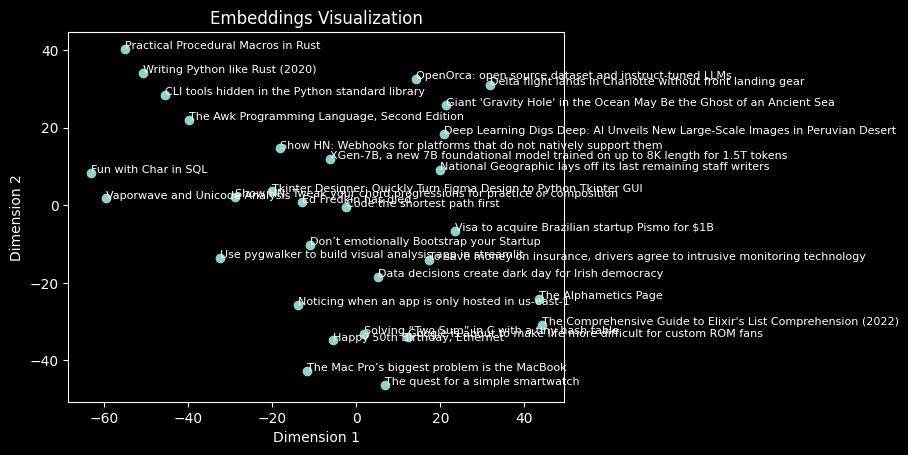

In [63]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Concatenate the embeddings as 1 vector
embeddings = []
embeddings_labels = []
for feed in feeds:
    for item in feed.items:
        embeddings.append(item.embeddings)
        embeddings_labels.append(item.title)
embeddings = np.array(embeddings)

# Reduce the dimensionality of the embeddings
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
embeddings_tsne = tsne.fit_transform(embeddings)

# Plot the embeddings
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1])
plt.title("Embeddings Visualization")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
for i, label in enumerate(embeddings_labels):
    plt.annotate(label, (embeddings_tsne[i, 0], embeddings_tsne[i, 1]), fontsize=8)
plt.show()

## Keywords

In [64]:
def extract_keywords(url: str):
    """
    Extract the keywords from the text
    """
    completion = openai.ChatCompletion.create(
        model=OPENAI_API_MODEL,
        messages=[
            {
                "role": "system",
                "content": "Extract the keywords from the text. Return the keywords as comma separated values.",
            },
            {"role": "user", "content": f"{url}"},
        ],
    )
    return completion.choices[0].message.content


for i, feed in enumerate(feeds):
    print("#articles:", feed.items.__len__())
    for j, item in enumerate(feed.items):
        print(f"article #{j}")
        print(item.link)
        try:
            keywords = extract_keywords(item.link)
            item.keywords = [kw.strip() for kw in keywords.split(",")]
            print(item.keywords)
        except:
            continue

#articles: 30
article #0
https://awk.dev/
['awk', 'dev']
article #1
https://xy2.dev/blog/simple-proc-macro/
['simple', 'proc-macro', 'rust', 'macros']
article #2
https://www.wbtv.com/2023/06/28/plane-lands-charlotte-douglas-international-airport-after-dealing-with-mechanical-issues/
['plane', 'lands', 'Charlotte Douglas International Airport', 'dealing', 'mechanical issues']
article #3
https://blog.apnic.net/2023/06/29/happy-50th-birthday-ethernet/
['happy 50th birthday', 'ethernet']
article #4
https://til.simonwillison.net/python/stdlib-cli-tools
['python', 'stdlib', 'cli tools']
article #5
https://blog.jonlu.ca/posts/us-east-1-latency
['us-east-1', 'latency']
article #6
https://www.scientificamerican.com/article/giant-gravity-hole-in-the-ocean-may-be-the-ghost-of-an-ancient-sea1/
['giant gravity hole', 'ocean', 'ghost', 'ancient sea']
article #7
https://erichartford.com/openorca
['openorca', 'Eric Hartford', 'renowned hacker', 'bug bounty hunter', 'software developer', 'security cons

## Vector DB

We store all embeddings inside a vector DB.


In [65]:
# Qdrant must be started
# docker run -p 6333:6333 qdrant/qdrant

import qdrant_client as qc
import qdrant_client.http.models as qc_models

qc_client = qc.QdrantClient(url="http://localhost:6333")

In [66]:
# we create a collection

QC_COLLECTION_NAME = "feeds"
QC_DIMENSION = 1536  # NB: This is the dimension of OpenAI embeddings with the model text-embedding-ada-002
QC_METRIC = qc_models.Distance.COSINE


def create_index():
    """
    Create index with default parameters
    """
    qc_client.recreate_collection(
        collection_name=QC_COLLECTION_NAME,
        vectors_config=qc_models.VectorParams(
            size=QC_DIMENSION,
            distance=QC_METRIC,
        ),
    )


create_index()

In [70]:
# We create and insert a vector for each article

import uuid

qc_points = []

for feed in feeds:
    for item in feed.items:
        id = str(uuid.uuid1().int)[:32]
        vector = item.embeddings
        payload = {
            "feed.title": feed.title,
            "feed.url": feed.link,
            "title": item.title,
            "url": item.link,
            "summary": "" if item.summary is None else item.summary,
            "keywords": "" if item.keywords is None else item.keywords,
        }
        point = qc_models.PointStruct(id=id, vector=vector, payload=payload)
        qc_points.append(point)

qc_client.upsert(collection_name=QC_COLLECTION_NAME, points=qc_points)

UpdateResult(operation_id=3, status=<UpdateStatus.COMPLETED: 'completed'>)

## Search space


To create a search on the index, we need to get the embeddings for the query string, and search the vector DB for the closest embeddings.


In [75]:
def search_idx(query: str, limit: int = 5):
    """
    Searches the index with a query string
    """
    query_embeddings = get_embdeddings(query)

    response = qc_client.search(
        collection_name=QC_COLLECTION_NAME,
        query_vector=query_embeddings,
        query_filter=None,
        limit=limit,
    )

    for article in response:
        print(article)
    return response


query = "How to capture carbon ?"
response = search_idx(query)

id='17984349-4038-7029-2924-481282025298' version=2 score=0.739072 payload={'feed.title': 'Hacker News', 'feed.url': 'https://news.ycombinator.com/', 'keywords': ['giant gravity hole', 'ocean', 'ghost', 'ancient sea'], 'summary': 'The linked article from Scientific American discusses an intriguing underwater phenomenon known as a "gravity hole." Researchers have discovered a massive gravity anomaly in the Indian Ocean, suggesting the presence of a ghostly reminder of an ancient sea. Using satellite data, scientists have found this gravity hole, which measures approximately 200 kilometers (124 miles) wide, and it is believed to be a remnant of an ancient tectonic plate boundary. The gravity hole could provide valuable insights into the geological history and dynamics of Earth\'s oceans.', 'title': "Giant 'Gravity Hole' in the Ocean May Be the Ghost of an Ancient Sea", 'url': 'https://www.scientificamerican.com/article/giant-gravity-hole-in-the-ocean-may-be-the-ghost-of-an-ancient-sea1/'